In [8]:
import torch
import torch.nn as nn

import os
import json
from tqdm import tqdm

import src.models as mdls
import src.utils as utils

# Face recognition imports
from src.models import Triplet
from src.models import ConvEmbedding

from src.utils import TripletLoss


#downloading datasets
config = utils.get_options()


if config['use_colab']:
    utils.colab()
else:
    utils.check_if_datasets_are_downloaded()


import src.dataloaders as dataloaders

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

Exception in thread Thread-16:
Traceback (most recent call last):
  File "c:\Users\pasin\anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\pasin\anaconda3\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\pasin\anaconda3\lib\subprocess.py", line 1479, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\pasin\anaconda3\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8e in position 0: invalid start byte
Exception in thread Thread-18:
Traceback (most recent call last):
  File "c:\Users\pasin\anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\pasin\anaconda3\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\pasin\anaconda3\lib\subprocess.py", line 1479, in _readerthread
    buffer.append(fh.r

Moving kaggle file

all datasets are in place


In [2]:
img_size = config['img_size']
# Define a directory to save the checkpoints
checkpoint_dir = "checkpoints/"

# Ensure the directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
#Face detection setup
test_size = 0.1

detection_model = mdls.InspectorGadjet()
# dataloader_for_detection = dataloaders.detection_dataloader
train_detection_dataloader, test_detection_dataloader = dataloaders.get_train_test_dataloaders(dataloaders.dataset, test_size=test_size)

# loss_fn = nn.MSELoss()
# loss_fn = mdls.combined_loss
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(detection_model.parameters(), lr=1e-3)
detection_model.to(device)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
early_stopper = utils.EarlyStopping(patience=10, min_delta=0.01)
# loss_fn.to(device)

None

In [4]:
len(train_detection_dataloader)

1113

tensor([[  1.0000,   0.0000,   7.3349,  21.7400,  29.0734],
        [  0.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [  1.0000,  50.4315,  18.8800,  73.3659,  38.5600],
        [  1.0000,   0.0000,  34.1504,  85.0446, 128.0000],
        [  1.0000,  55.1178,  13.2866,  88.4956,  46.2985],
        [  1.0000,  77.5474,  16.0000,  93.1636,  26.4000],
        [  1.0000,  58.8000, 100.2666,  64.8000, 109.6000],
        [  0.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [  1.0000,  73.3771,  44.1856, 126.3644, 128.0000],
        [  0.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [  1.0000,  50.5265,  46.1251,  68.7747,  76.0779],
        [  0.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [  1.0000,  75.3791,  11.3600, 109.3358,  27.1200],
        [  0.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [  1.0000,  19.8835,  24.6913,  77.7942,  93.4321],
        [  1.0000,  13.5948,  40.5751,  72.9934, 123.6078]],
       dtype=torch.float64)


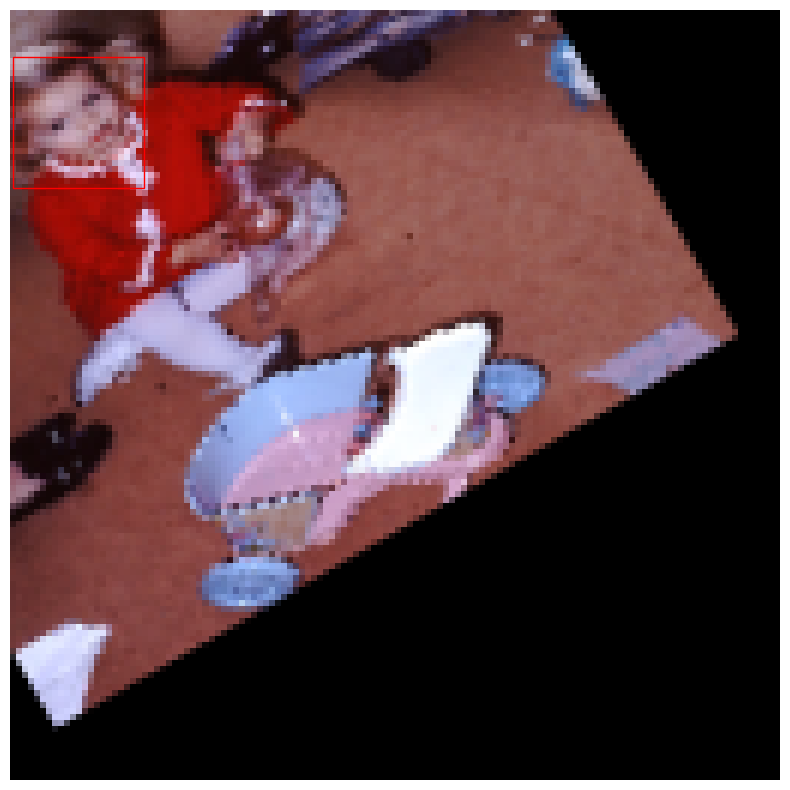

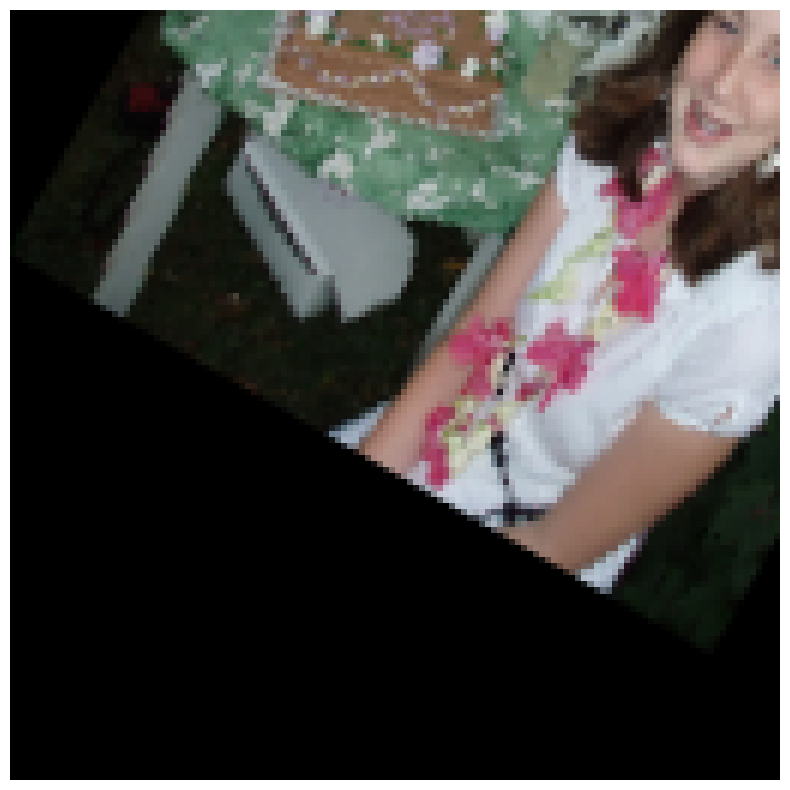

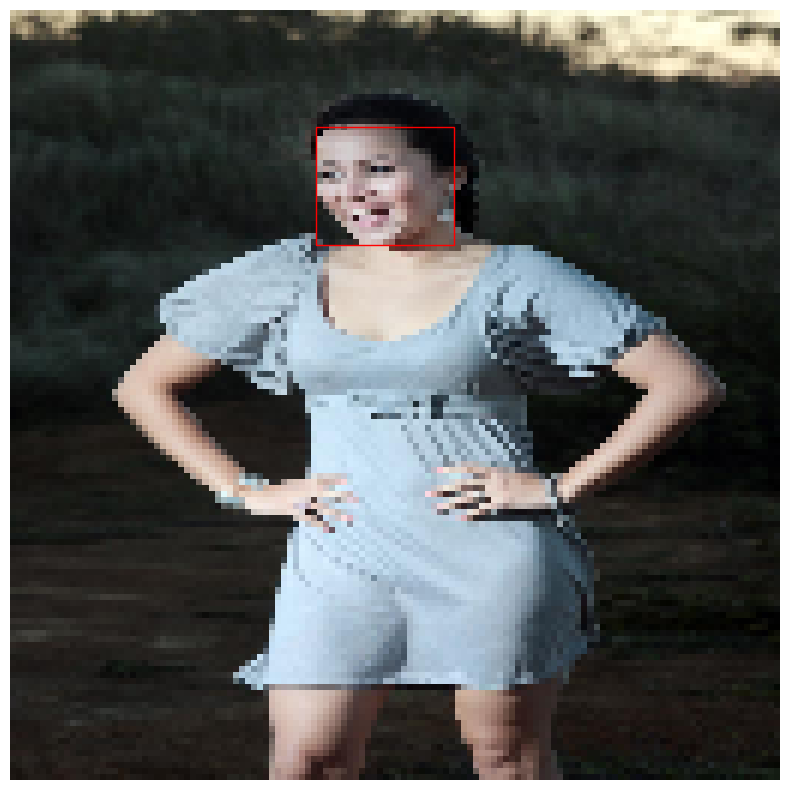

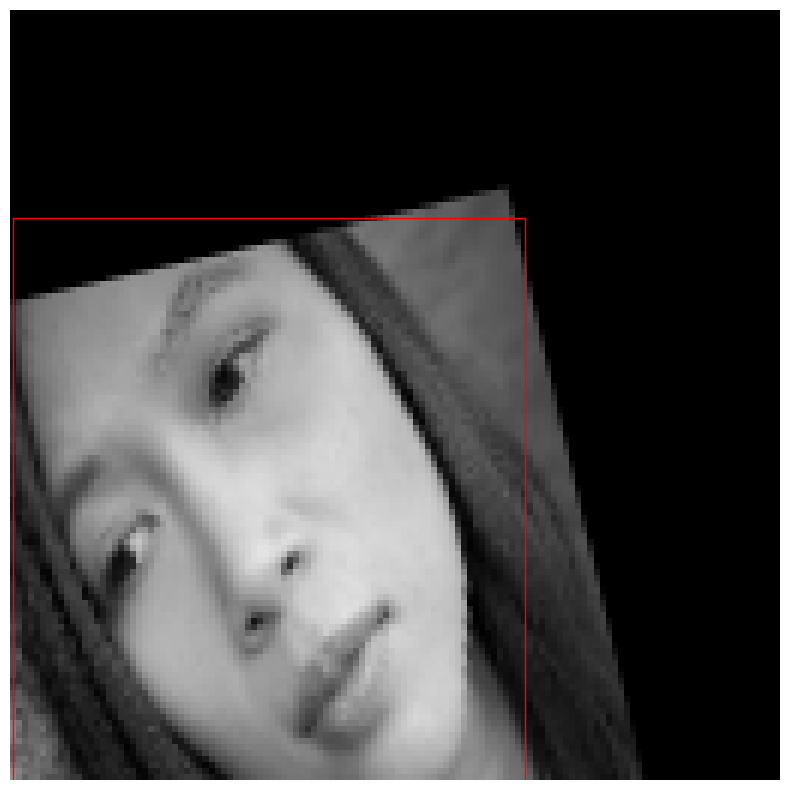

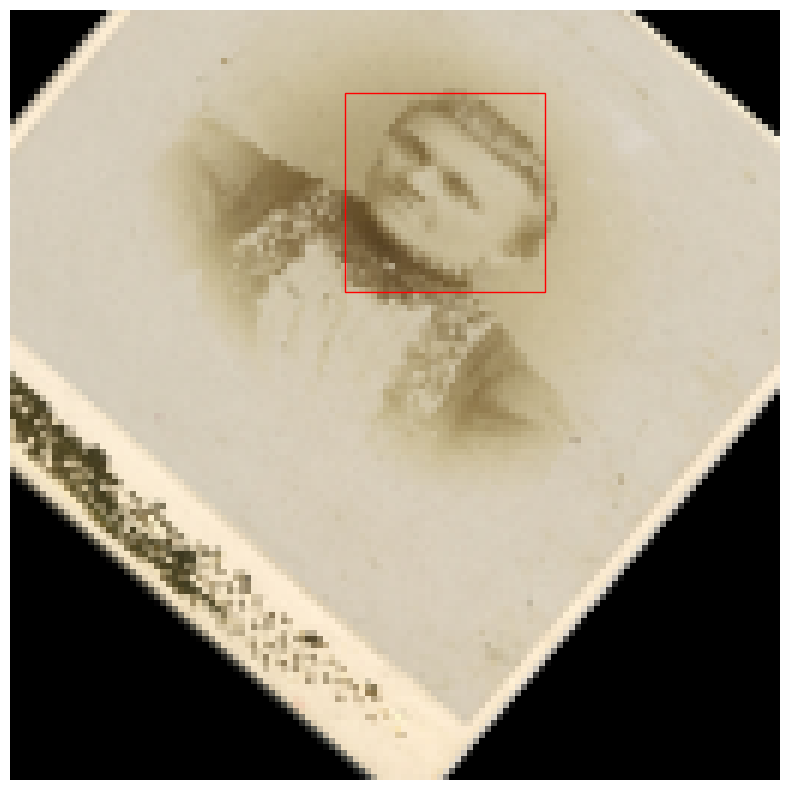

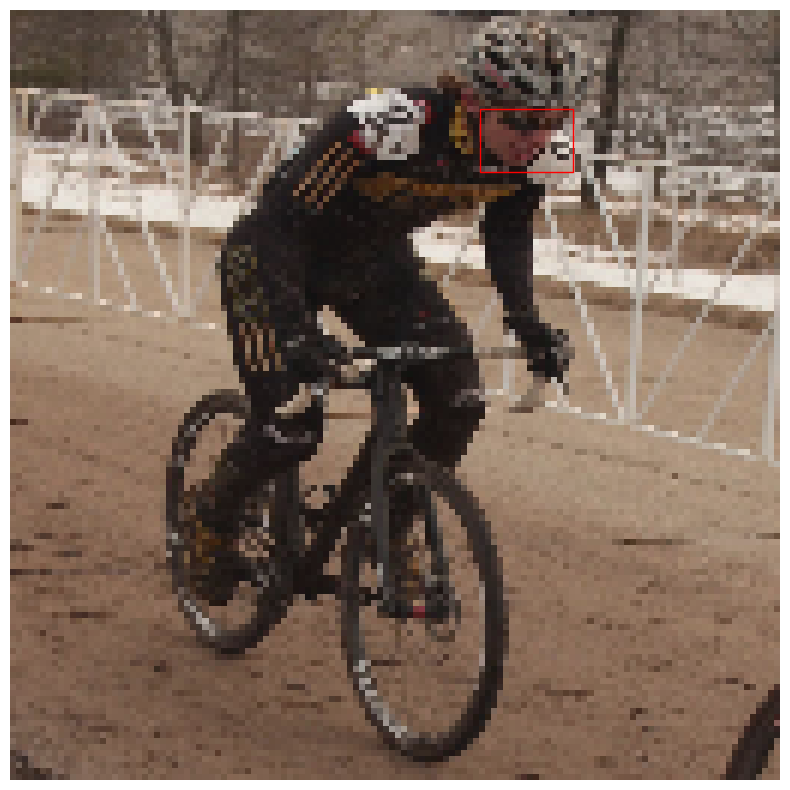

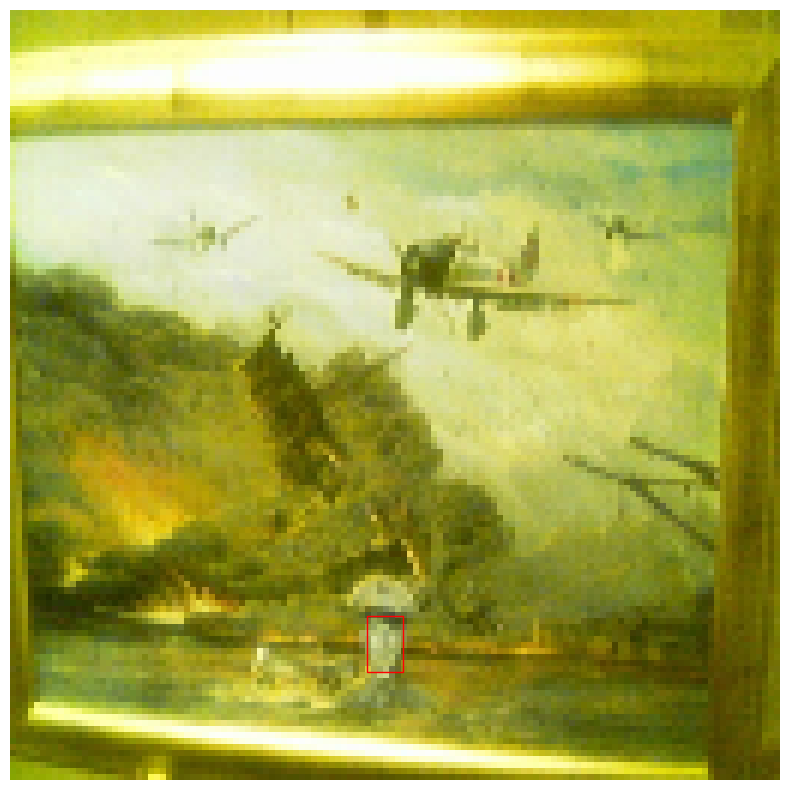

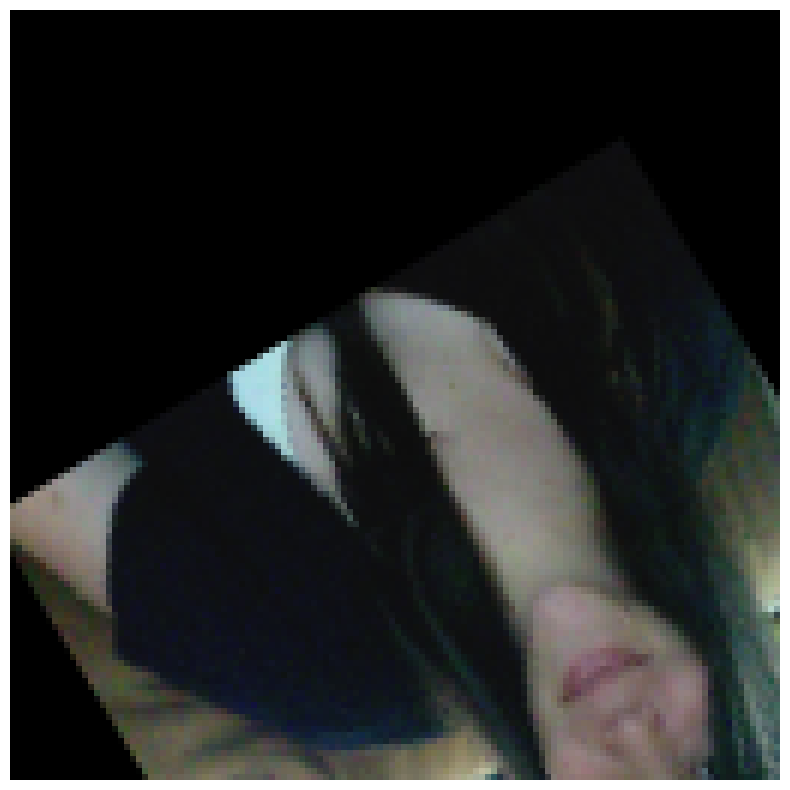

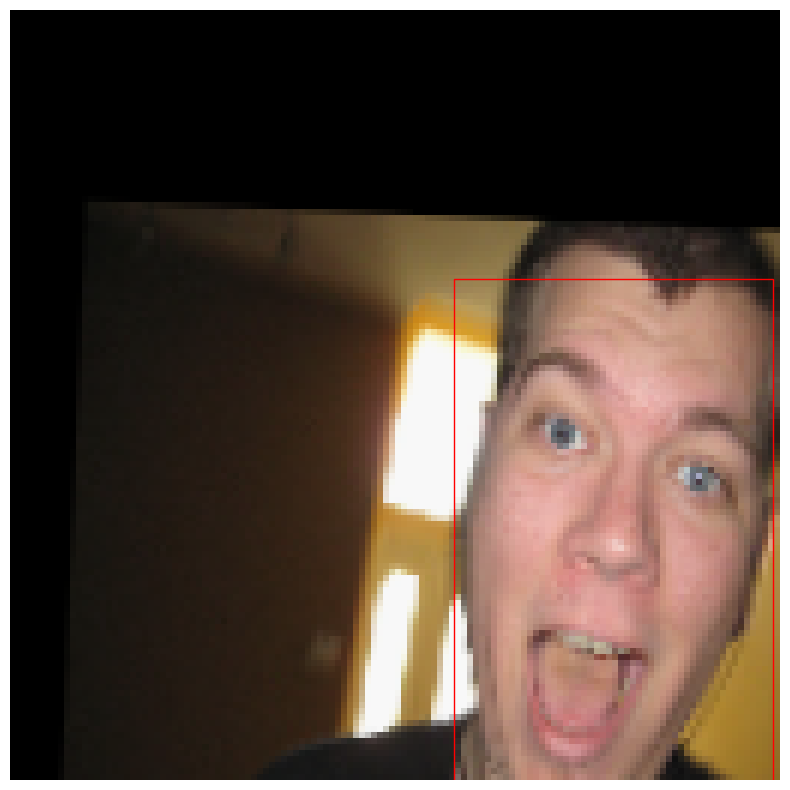

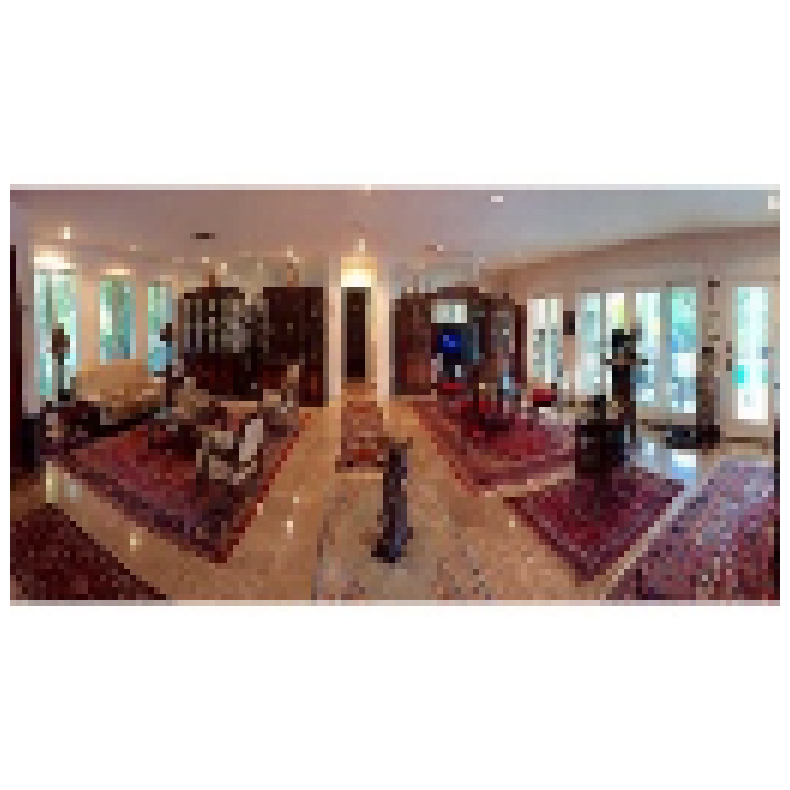

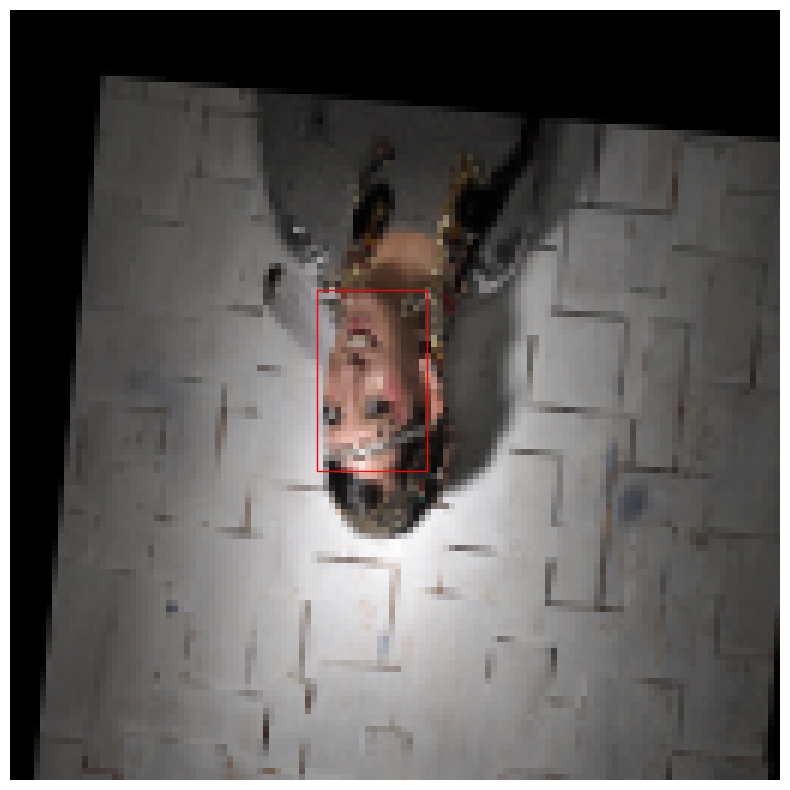

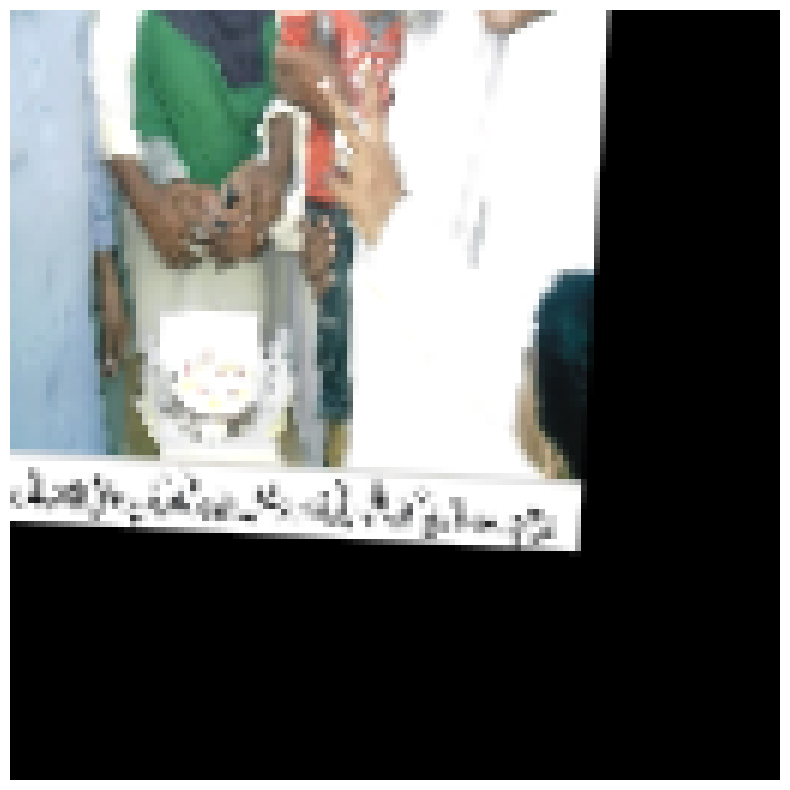

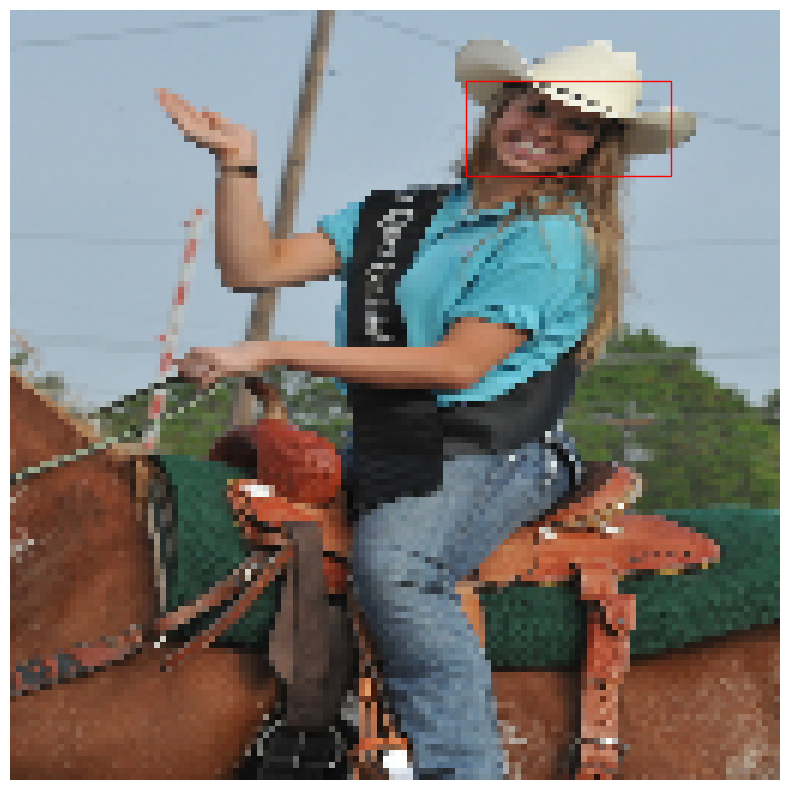

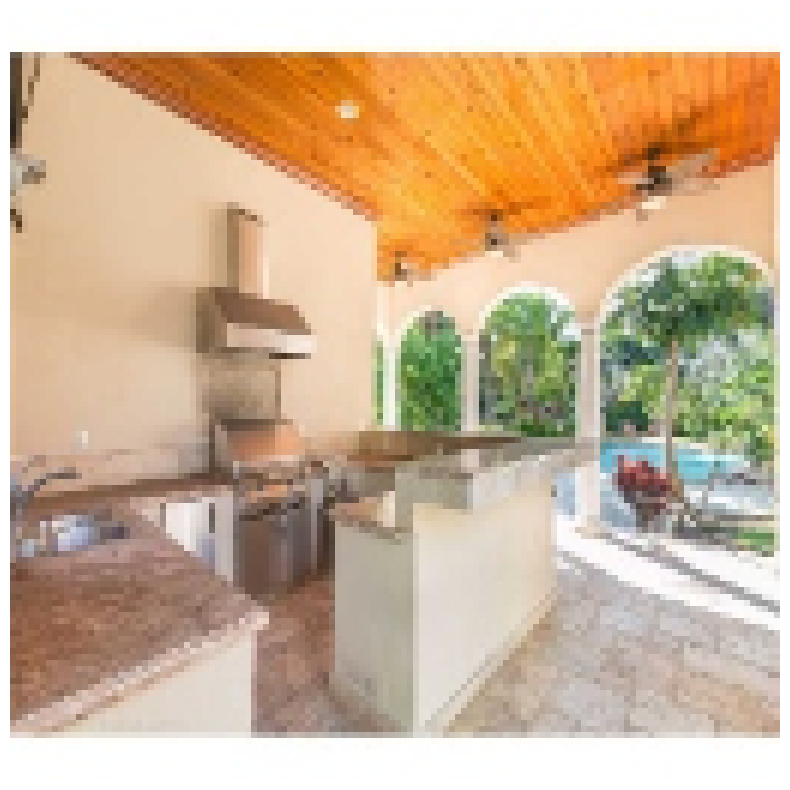

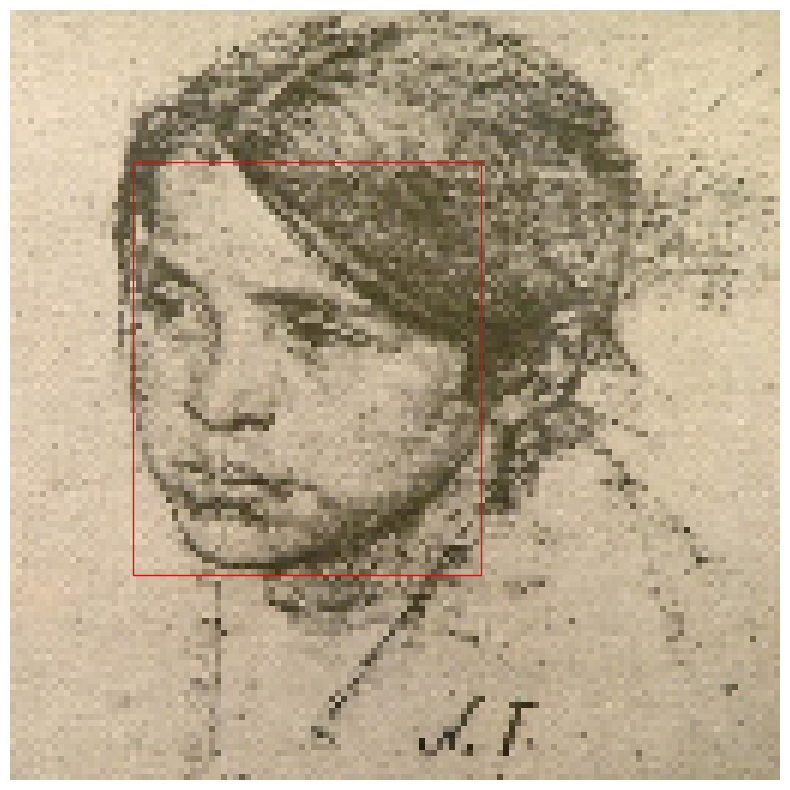

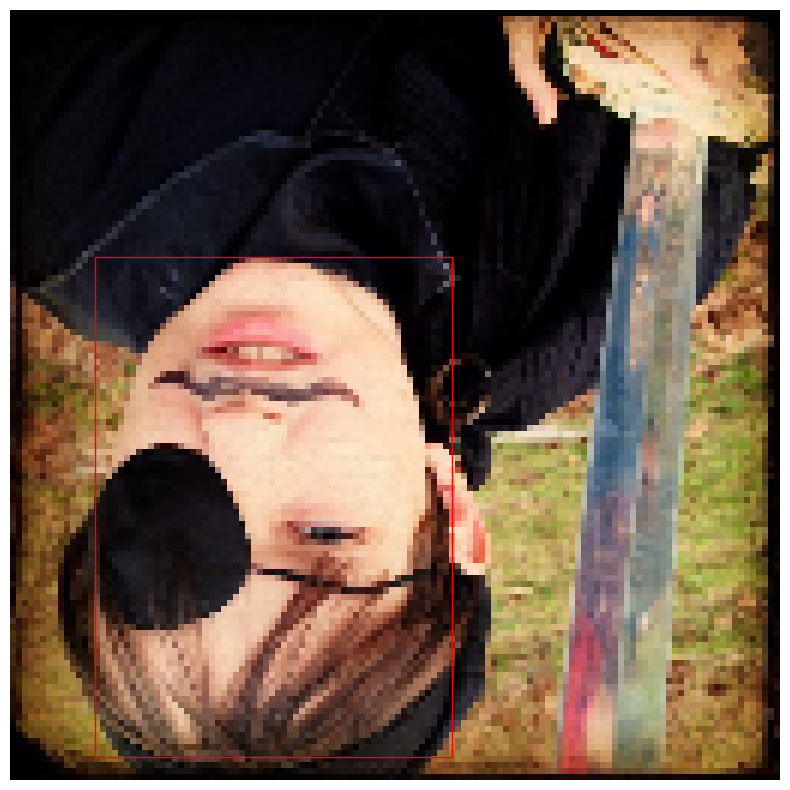

In [5]:
### Function to check how albumentation works
batch = next(iter(train_detection_dataloader))
utils.plot_images_with_bboxes(batch)

In [5]:
det_epochs = config['detection_epochs']
det_logging = config['detection_logging']
log_interval = config["detection_log_wieghts_interval"]
test_img_path = ''

if det_logging: 
    # read secrets for cometml logging
    with open('secrets.json') as secrets_file:
        secrets = json.load(secrets_file)

    # init experimenxt
    experiment = Experiment(
        api_key=secrets["api_key"],
        project_name=secrets["project_name"],
        workspace="reu-ds-club", 
        tags=["detection"],
    )

    hyper_params = {
        "model_name": config["model"],
        "use_colab": config['use_colab'], 
        "epochs": det_epochs,
        "batch_size": config['batch_size'], 
        "image_size": config['img_size'], 
    }

    experiment.log_parameters(hyper_params)

for epoch in range(det_epochs):
    epoch_loss = 0.0
    for sample in (pbar := tqdm(train_detection_dataloader)):

        img, box = sample[0].to(device), sample[1].to(device)
        img = img.to(torch.float32)

        box = box.to(torch.float32)
        optimizer.zero_grad()
        pred = detection_model(img)
        # loss = loss_fn(pred, box)
        

        # loss = loss_fn(pred[0], pred[1], box)
        
        loss = loss_fn(pred, box)

        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    
    val_loss = utils.validate_model(detection_model, test_detection_dataloader, loss_fn, device)

    print(f"Epoch: {epoch}\tLoss: {epoch_loss / len(train_detection_dataloader)}\tVal loss: {val_loss}")
    utils.save_img_after_epoch(test_img_path, detection_model, epoch, device)

    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping")
        break

    checkpoint_filename = os.path.join(checkpoint_dir, f"{epoch}_checkpoint_detection.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': detection_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, checkpoint_filename)

    if det_logging:
        experiment.log_metric("loss", epoch_loss, step=epoch)
    
    # logging model weights (accorging to log_interval + last epoch)
    if det_logging and (epoch % log_interval == 0 or epoch == det_epochs-1):
        torch.save(detection_model, 'det_model.pth')
        experiment.log_model(name = f"model-epoch-{epoch}", file_or_folder = 'det_model.pth', file_name = f"det-model-epoch-{epoch}")
        experiment.log_asset(file_data = 'det_model.pth', file_name = f"det_model-epoch-{epoch}")
        print("save model")


if det_logging:
    experiment.end()

  0%|          | 0/905 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [3]:
#Face recognition setup
conv = ConvEmbedding().to(device)
triplet_model = Triplet(conv).to(device)
loss_for_recognition = TripletLoss(margin=5)
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=1e-3)

In [6]:
recognition_dataloader = dataloaders.recognition_dataloader
len(recognition_dataloader)


16332

In [ ]:
rec_epochs = config['recognition__epochs']
rec_logging = config['recognition_logging']
rec_log_interval = config["recognition_log_wieghts_interval"]

if rec_logging: 
    # read secrets for cometml logging
    with open('secrets.json') as secrets_file:
        secrets = json.load(secrets_file)

    # init experimenxt
    experiment = Experiment(
        api_key=secrets["api_key"],
        project_name=secrets["project_name"],
        workspace="reu-ds-club", 
        tags=["recognition"],
    )

    hyper_params = {
        "model_name": config["model"],
        "use_colab": config['use_colab'], 
        "epochs": rec_epochs,
        "batch_size": config['batch_size'], 
        "image_size": config['img_size'], 
    }

    experiment.log_parameters(hyper_params)

for epoch in range(rec_epochs):
    epoch_loss = 0

    for i, triplet in enumerate(recognition_dataloader):

        anc, pos, neg = triplet

        preds = triplet_model(anc.to(device), pos.to(device), neg.to(device))

        loss_val = loss_for_recognition(*preds)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        epoch_loss += loss_val.item()
        
        
    print(f'{epoch} | EPOCH LOSS: {loss_val}')
    checkpoint_filename = os.path.join(checkpoint_dir, f"{epoch}_checkpoint_recognition.pth")

    torch.save({
        'epoch': epoch,
        'model_state_dict': triplet_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, checkpoint_filename)

    if rec_logging:
        experiment.log_metric("loss", epoch_loss, step=epoch)
    
    # logging model weights (accorging to log_interval + last epoch)
    if rec_logging and (epoch % log_interval == 0 or epoch == rec_epochs-1):
        torch.save(triplet_model, 'rec_model.pth')
        experiment.log_model(name = f"rec_model-epoch-{epoch}", file_or_folder = 'rec_model.pth', file_name = f"rec_model-epoch-{epoch}")
        experiment.log_asset(file_data = 'rec_model.pth', file_name = f"rec_model-epoch-{epoch}")
        print("save model")


if rec_logging:
    experiment.end()

https://github.com/timesler/facenet-pytorch#pretrained-models - main page, to get to know how it works
https://github.com/timesler/facenet-pytorch/blob/master/examples/finetune.ipynb - if we want to finetune it

In [ ]:
# pip install pip install facenet-pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device) # or pretrained='casia-webface'

In [ ]:
batch = next(iter(recognition_dataloader))

names = ['arc', 'pos', 'neg']
cur_imgs = torch.stack([batch[0][0], batch[0][1], batch[0][2]])
embeddings = resnet(cur_imgs).detach().cpu()
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]

In [ ]:
pd.DataFrame(dists, columns=names, index=names) # dataframe with distances 